In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
line_mics_df = pd.read_excel("datoteke/WhiteNoise_4mic_5cm_96kHz.xlsx", header=0, usecols="A:D")
line_mics_raw = line_mics_df.to_numpy()
line_signal_1 = line_mics_raw[:, 0]
line_signal_2 = line_mics_raw[:, 1]
line_signal_3 = line_mics_raw[:, 2]
line_signal_4 = line_mics_raw[:, 3]
fs = 96000
mic_dist = 5e-2 


In [5]:
angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]
dN_all = []
for i in angles:
    dN = (mic_dist * np.cos(np.radians(i)) * fs) / (343)
    dN_all.append(round(dN))

dN_all = abs(np.array(dN_all))
angles_all = {angles[i]: [] for i in range(len(angles))}


In [6]:
for i in angles:
    dN = dN_all[angles.index(i)]
    if i < 90:
        angle_signal_1 = line_signal_1
        angle_signal_2 = np.roll(line_signal_2, -dN)
        angle_signal_3 = np.roll(line_signal_3, -2*dN)
        angle_signal_4 = np.roll(line_signal_4, -3*dN)
    elif i == 90:
        angle_signal_1 = line_signal_1
        angle_signal_2 = line_signal_2
        angle_signal_3 = line_signal_3
        angle_signal_4 = line_signal_4
    else:
        angle_signal_1 = np.roll(line_signal_1, -3*dN)
        angle_signal_2 = np.roll(line_signal_2, -2*dN)
        angle_signal_3 = np.roll(line_signal_3, -dN)
        angle_signal_4 = line_signal_4
    angle_sum = angle_signal_1 + angle_signal_2 + angle_signal_3 + angle_signal_4
    angles_all[i] = angle_sum

In [7]:
prms_all = {angles[i]: [] for i in range(len(angles))}
for i in angles:
    angle_sum = angles_all[i]
    prms = np.sqrt(1/len(angle_sum) * np.mean(angle_sum**2))
    prms_all[i] = prms

max_prms = max(prms_all.values())
max_angle = np.deg2rad([k for k, v in prms_all.items() if v == max_prms][0])

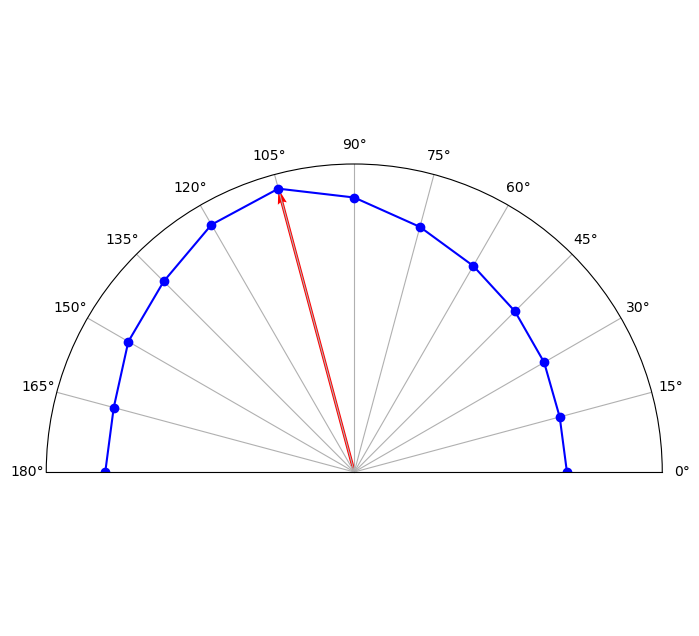

In [8]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw = dict(polar=True))
ax.set_thetagrids(angles)
ax.set_thetamax(180) 
ax.set_rticks([1, 2, 3, 4, 5, 6, 7, 8])
ax.set_rlabel_position(180)
ax.grid(True)
angles_rad = np.deg2rad(angles)
prms_values = [list(prms_all.values())][0]
ax.plot(angles_rad, prms_values, marker='o', color='b', linestyle='-')


ax.quiver(
    max_angle, 0,          # start point (theta, r)
    0, max_prms,  # vector (dtheta, dr)
    angles='xy',       # interpret dtheta/dr as delta in axes
    scale_units='xy',
    scale=1,           # no scaling
    color='red',
    width=0.005        # arrow thickness
)
plt.show()


In [ ]:
square_mics_df = pd.read_excel("datoteke\CircularArray_WhiteNoise_4mic_5cm_96kHz.xlsx", header=0, usecols="A:D")
square_mics_raw = square_mics_df.to_numpy()
square_signal_1 = square_mics_raw[:, 0]
square_signal_2 = square_mics_raw[:, 1]
square_signal_3 = square_mics_raw[:, 2]
square_signal_4 = square_mics_raw[:, 3]
signals = np.array([square_signal_1, square_signal_2, square_signal_3, square_signal_4])

fs = 96000  #hz             
c = 343              
num_mics = 4
d = 5e-2 / np.sqrt(2)         

mic_positions = np.array([
    [-d/2,  d/2],  #1: top-left
    [ d/2,  d/2],  #2: top-right
    [ d/2, -d/2],  #3: bottom-left
    [-d/2, -d/2],  #4: bottom-right
])

angles = np.arange(0, 360, 15) 
prms_all = {angles[i]: [] for i in range(len(angles))}

for angle in angles:
    theta = np.deg2rad(angle)
    direction = np.array([np.sin(theta), -np.cos(theta)])  
    delays = np.dot(mic_positions, direction) / c
    delay_samples = np.round(delays * fs).astype(int)
    
    aligned = []
    for m in range(num_mics):
        sig = signals[m]
        if delay_samples[m] > 0:
            sig_aligned = sig[delay_samples[m]:]
        elif delay_samples[m] < 0:
            sig_aligned = np.pad(sig, (abs(delay_samples[m]), 0))
        else:
            sig_aligned = sig
        aligned.append(sig_aligned)
    
    min_len = min(len(s) for s in aligned)
    aligned = np.array([s[:min_len] for s in aligned])
    summed_signal = np.sum(aligned, axis=0)
    prms = np.sqrt(1/len(summed_signal) * np.mean(summed_signal**2))
    prms_all[angle] = prms


max_prms = max(prms_all.values())
max_angle_deg = [k for k, v in prms_all.items() if v == max_prms][0]
max_angle_rad = np.deg2rad([k for k, v in prms_all.items() if v == max_prms][0])


print(f"Estimated DOA: {max_angle_deg}°")


Estimated DOA: 120°


C:\Users\Jernej Kusar\AppData\Local\Temp\ipykernel_24992\2909404519.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


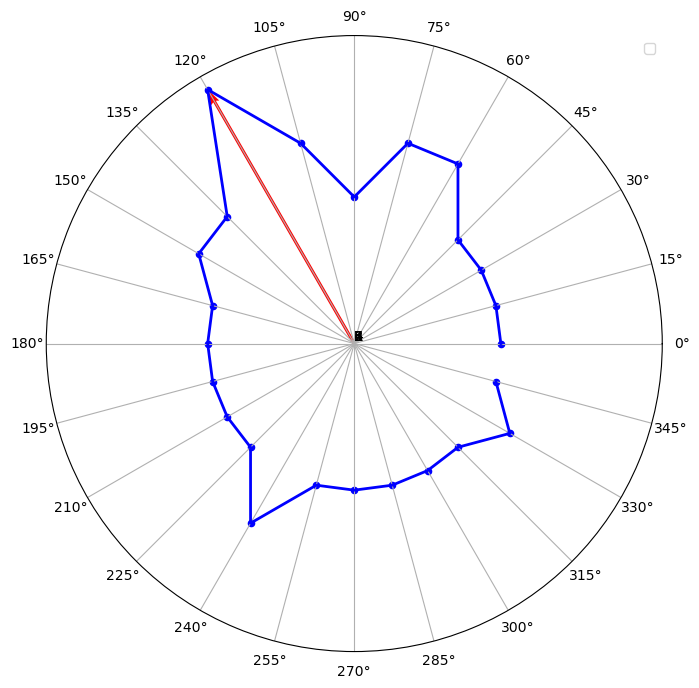

In [ ]:

angles_rad = np.deg2rad(angles)
prms_values = [list(prms_all.values())][0]
fig, ax = plt.subplots(figsize=(10,8), subplot_kw=dict(polar=True))

ax.set_thetagrids(angles)
#ax.set_thetamax(180) 
ax.set_rticks([1, 2, 3, 4, 5, 6, 7, 8])
ax.set_rlabel_position(180)
ax.plot(angles_rad, prms_values, color='b', linewidth=2, ls="-")
ax.scatter(angles_rad, prms_values, color='b', s=20)


ax.quiver(
    max_angle_rad, 0,          # start point (theta, r)
    0, max_prms,  # vector (dtheta, dr)
    angles='xy',       # interpret dtheta/dr as delta in axes
    scale_units='xy',
    scale=1,           # no scaling
    color='red',
    width=0.005        # arrow thickness
)


ax.legend(loc='upper right')
plt.show()